In [1]:
## tips
### do the data cleaning first
#### earliness : how early each ship has arrived at the port
#### tardiness : how late each ship has arrived at the port
#### setup time : the time between each arrival and start of operation
#### UT : time between operation end and ship disposal
#### We got two type of ships in the system, Liner and Feeder
#### 7592 records in the dataset and each row denotes to one ship
#### check iid condition for features and fit a distribution to them if needed
#### statistical indicators - goodness of fit and ....
#### partition the dataset for each ship - check if it's better to fit a single distribution to the entire dataset or it's better to fit a particular one to each ship dataset
#### more creativity means higher score
#### for more information checkout the class slide on R

In [1]:
import warnings
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._continuous_distns import _distn_names
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from scipy import stats
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
portdata=pd.read_csv('PortData.csv')
#Drop No column
portdata=portdata.iloc[1:,:]
portdata=portdata.drop(columns={'No'})
portdata.head()


,GRT,Length,TerminalName,TEU,VoyageType,Interval,EarlinessTardiness,ST,OT,UT
1,17618.0,201,1,1861,Feeder,18.23,13,4.00,31.40,3.27
2,16694.0,174,1,1223,Liner,8.90,64,2.72,46.50,5.78
3,29873.0,210,1,605,Liner,30.38,0,1.65,25.85,4.08
4,15670.0,168,1,1502,Liner,12.00,7,4.38,56.13,5.82
5,16100.0,170,1,268,Liner,8.17,15,0.77,7.63,1.60


### data cleaning

In [4]:
portdata.isnull().sum()

GRT                   0
Length                0
TerminalName          0
TEU                   0
VoyageType            0
Interval              0
EarlinessTardiness    0
ST                    0
OT                    0
UT                    0
dtype: int64

In [5]:
Liner=portdata[portdata.VoyageType=='Liner'].reset_index(drop=True)
Feeder=portdata[portdata.VoyageType=='Feeder'].reset_index(drop=True)

In [6]:
Liner.head()

,GRT,Length,TerminalName,TEU,VoyageType,Interval,EarlinessTardiness,ST,OT,UT
0,16694.0,174,1,1223,Liner,8.90,64,2.72,46.50,5.78
1,29873.0,210,1,605,Liner,30.38,0,1.65,25.85,4.08
2,15670.0,168,1,1502,Liner,12.00,7,4.38,56.13,5.82
3,16100.0,170,1,268,Liner,8.17,15,0.77,7.63,1.60
4,36014.0,240,1,4082,Liner,14.83,0,2.22,76.73,1.93


Text(0.5, 1.0, 'Liner')

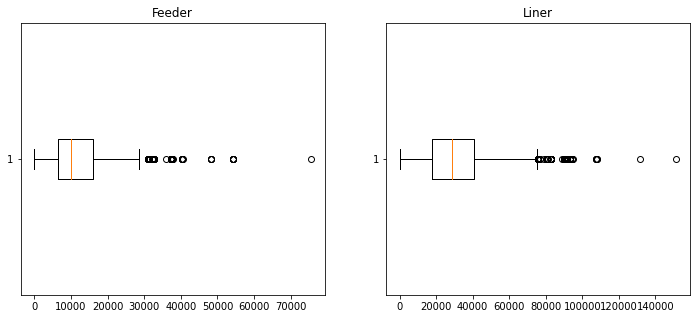

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.GRT.values,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.GRT,vert=False)
ax2.set_title('Liner')

In [8]:
Q1_liner = Liner['GRT'].quantile(0.25)
Q3_liner = Liner['GRT'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['GRT'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['GRT'] <= Q3_liner + 1.5 *IQR_liner)
Liner_GRT=Liner.loc[filter1].GRT
 ##### 
Q1_Feeder = Feeder['GRT'].quantile(0.25)
Q3_Feeder = Feeder['GRT'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['GRT'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['GRT'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_GRT=Feeder.loc[filter2].GRT


Text(0.5, 1.0, 'Liner')

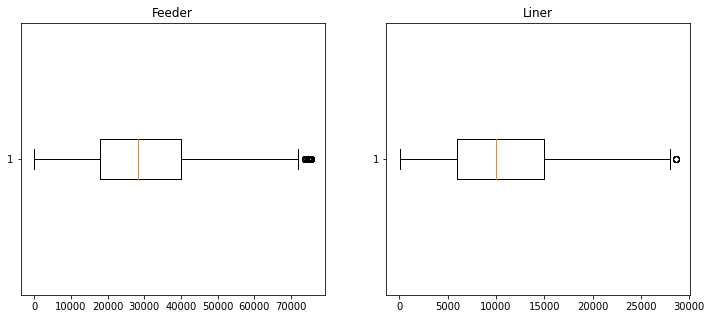

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Liner_GRT,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Feeder_GRT,vert=False)
ax2.set_title('Liner')

Text(0.5, 1.0, 'Liner')

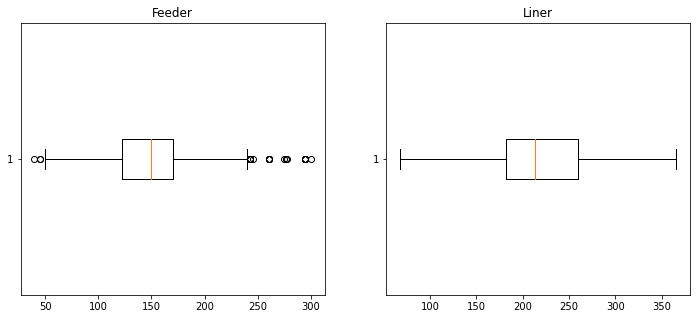

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.Length.values,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.Length,vert=False)
ax2.set_title('Liner')

In [11]:
Q1_liner = Liner['Length'].quantile(0.25)
Q3_liner = Liner['Length'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['Length'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['Length'] <= Q3_liner + 1.5 *IQR_liner)
Liner_Length=Liner.loc[filter1].Length
##### 
Q1_Feeder = Feeder['Length'].quantile(0.25)
Q3_Feeder = Feeder['Length'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['Length'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['Length'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_Length=Feeder.loc[filter2].Length

Text(0.5, 1.0, 'Liner')

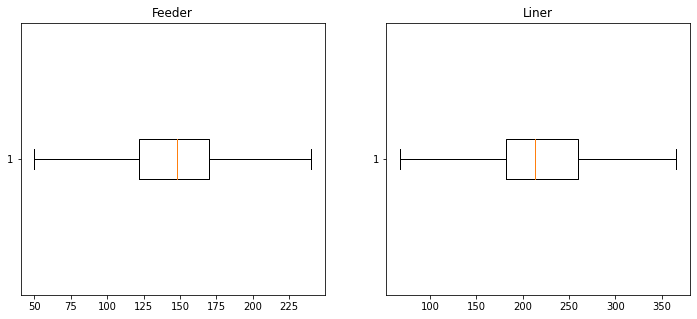

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder_Length,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner_Length,vert=False)
ax2.set_title('Liner')

Text(0.5, 1.0, 'Liner')

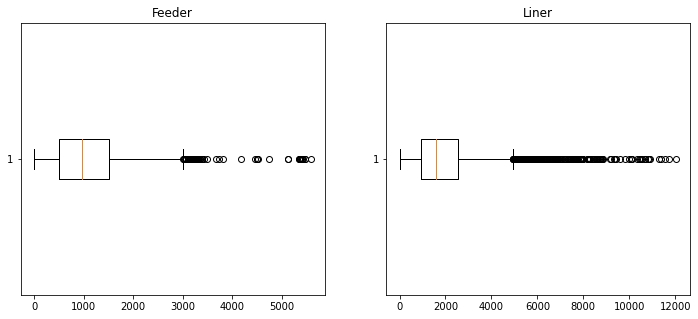

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder.TEU,vert=False)
ax1.set_title('Feeder')
ax2.boxplot(Liner.TEU,vert=False)
ax2.set_title('Liner')

In [14]:
Q1_liner = Liner['TEU'].quantile(0.25)
Q3_liner = Liner['TEU'].quantile(0.75)
IQR_liner = Q3_liner - Q1_liner    #IQR is interquartile range. 
filter1 = (Liner['TEU'] >= Q1_liner - 1.5 * IQR_liner) & (Liner['TEU'] <= Q3_liner + 1.5 *IQR_liner)
Liner_TEU=Liner.loc[filter1].TEU
##### 
Q1_Feeder = Feeder['TEU'].quantile(0.25)
Q3_Feeder = Feeder['TEU'].quantile(0.75)
IQR_Feeder = Q3_Feeder - Q1_Feeder    #IQR is interquartile range. 
filter2 = (Feeder['TEU'] >= Q1_Feeder - 1.5 * IQR_Feeder) & (Feeder['TEU'] <= Q3_Feeder + 1.5 *IQR_Feeder)
Feeder_TEU=Feeder.loc[filter2].TEU

Text(0.5, 1.0, 'Liner')

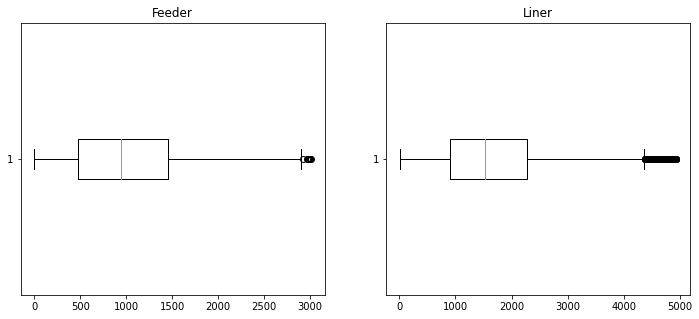

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(12,5)
ax1.boxplot(Feeder_TEU,vert=False,whis=1.5)
ax1.set_title('Feeder')
ax2.boxplot(Liner_TEU,vert=False,whis=1.5)
ax2.set_title('Liner')

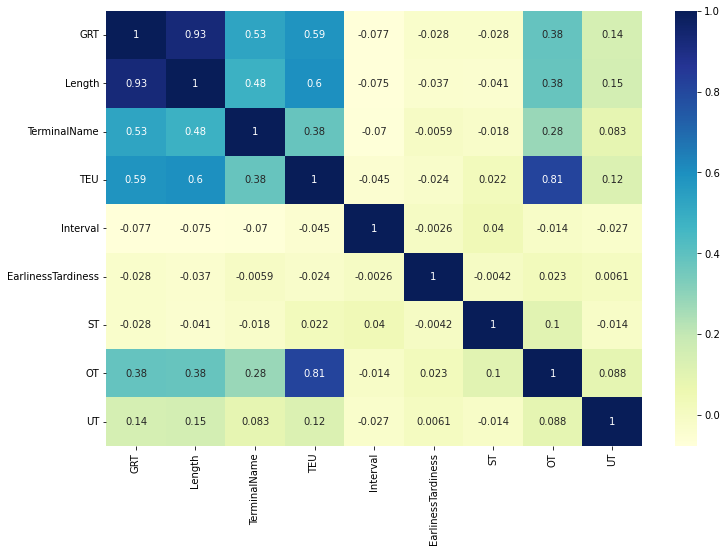

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(Liner.corr(),annot=True,cmap='YlGnBu')
plt.show()  

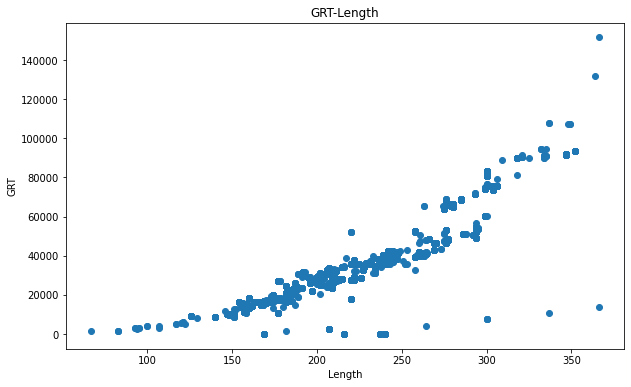

In [17]:
plt.figure(figsize=(10,6))
plt.title('GRT-Length')
plt.xlabel('Length')
plt.ylabel('GRT')
plt.plot(Liner.Length.values , Liner.GRT.values , 'o')
#plt.plot(x,y_pred,'r')

In [423]:
model = LinearRegression()
x=Liner.Length.values.reshape(-1,1)
y=Liner.GRT.values
model=model.fit(x,y)
y_pred=model.predict(x)

In [421]:
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)
model2 = LinearRegression().fit(x_poly, y)
y_pred2=model2.predict(x_poly)
y_pred2

array([17369.05300281, 27068.89670932, 16116.30359318, ...,
       29389.62526195, 54573.03720719, 28046.16650768])

   ## check for i.i.d

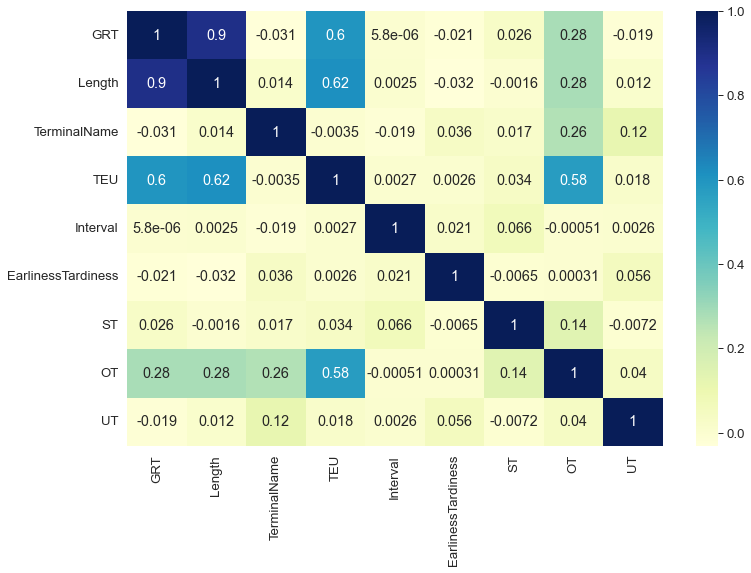

In [325]:
plt.figure(figsize=(12,8))
sns.heatmap(Feeder.corr(),annot=True,cmap='YlGnBu')
plt.show()

Text(0, 0.5, 'count')

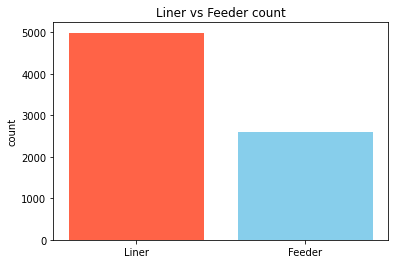

In [35]:
plt.bar(['Liner','Feeder'],[len(Liner),len(Feeder)],color=['tomato','skyblue'])
plt.title('Liner vs Feeder count')
plt.ylabel('count')

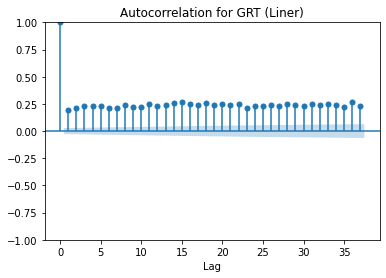

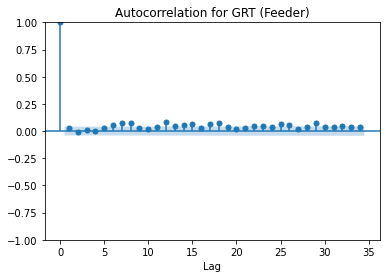

In [37]:
plot_acf(Liner_GRT)
plt.title('Autocorrelation for GRT (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_GRT)
plt.xlabel('Lag')
plt.title('Autocorrelation for GRT (Feeder)')
plt.show()

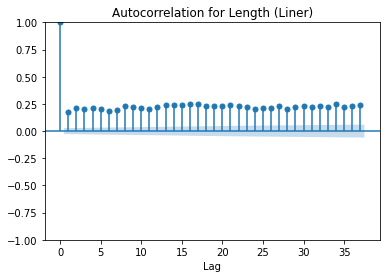

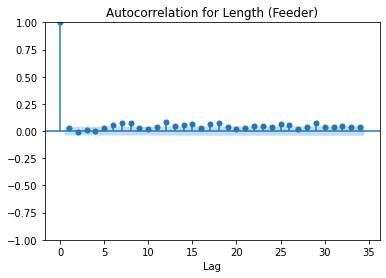

In [38]:
plot_acf(Liner_Length)
plt.title('Autocorrelation for Length (Liner)')
plt.xlabel('Lag')
plot_acf(Feeder_GRT)
plt.xlabel('Lag')
plt.title('Autocorrelation for Length (Feeder)')
plt.show()

<BarContainer object of 20 artists>

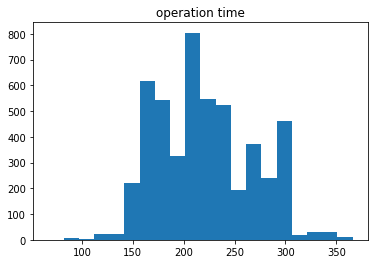

In [56]:
plt.figure()
plt.title('operation time')
plt.hist(Liner_Length,bins=20)[2]

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

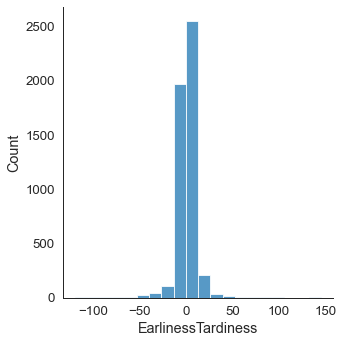

In [57]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.5)
sns.displot(data=Liner.EarlinessTardiness,  kind="hist",bins=20)

In [ ]:
get_distributions()

,sumsquare_error,aic,bic,kl_div
erlang,0.000191,1820.696385,-132819.571633,inf
beta,0.000208,1804.279367,-132158.328893,inf
norm,0.001379,3594.377073,-117803.067144,inf
expon,0.002816,1464.679448,-112383.400674,inf
triang,0.005262,1127.562785,-107627.902873,inf


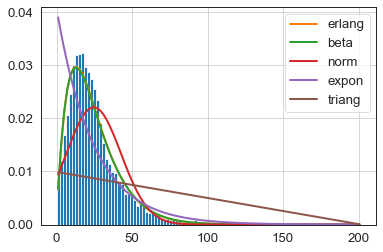

In [318]:
#Create a Fitter instance by calling the Fitter( )
#Supply the data (height) and distributions list if you have a basic idea of the distributions that might fit your data
#Apply the .fit( ) method
#Generate the fitted distribution summary using .summary( ) method
f = Fitter(portdata.OT,
           distributions=['gamma',
                          "beta",
                          "norm",'triang','expon','erlang'])
f.fit()
f.summary()

In [324]:
f.get_best()
f.fitted_param["beta"]

(2.1010034628277308,
 1812020499792.1294,
 -0.3700023278500124,
 21604145372115.617)

In [92]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

,sumsquare_error,aic,bic,kl_div
norm,27.719967,66.956419,-3571.786768,inf
erlang,28.694086,71.905988,-3530.340976,inf
triang,56.564075,-34.295291,-2851.657953,inf
expon,357.578425,-32.090161,-1014.585060,inf


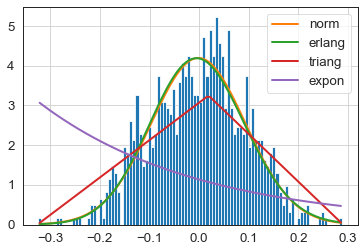

In [93]:
f = Fitter(s,distributions=["norm",'triang','expon','erlang'])
f.fit()
f.summary()

In [149]:
#k-s chi-square goodness of fit
stats.kstest(portdata.EarlinessTardiness, stats.norm.cdf)

KstestResult(statistic=0.3513771240128273, pvalue=0.0)

In [163]:
stats.anderson(s,dist='norm')

AndersonResult(statistic=0.9977561255002456, critical_values=array([0.574, 0.653, 0.784, 0.914, 1.088]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [309]:
#  The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals.
#  Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
#  This statistic will always be between 0 and 4.
#  The closer to 0 the statistic, the more evidence for positive serial correlation.
#  The closer to 4, the more evidence for negative serial correlation
durbin_watson(Liner.Length)

0.06261660350854868